In [1]:
from train import *
from model import *
from helpers import *

import os
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import clear_output

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    dtype = torch.FloatTensor

num GPUs 2


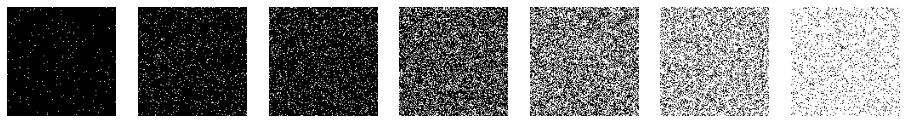

In [2]:
num_of_low_shots = 24
num_of_val = 24
image_size = 128

# given mask
img_mask_pil = Image.open('./mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_var = np_to_var(mask_np).type(dtype) # float within 0~1

# random masks
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
masks = torch.zeros(len(ratios), 3, image_size, image_size).to(device)

plt.figure(figsize=(16, 8))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, 128, 128)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

In [3]:
# low shots
# Root directory for dataset
data_root = "./CelebA_data/celeba"

batch_size = 2
data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor() ]))

train_set = IndexedDataset(torch.utils.data.Subset(data_set, range(52, 52+num_of_low_shots, 1)))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# validate images
val_set = IndexedDataset(torch.utils.data.Subset(data_set, range(27, 51, 1)))
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

In [5]:
code_dim = 128
Z = np.random.normal(size=(len(train_set), code_dim)).astype(np.float32) # (number of low shots, 128)
Z = torch.tensor(Z, requires_grad=True).to(device)

LV_Z = LatentVariables(Z).to(device)
pretrain_decoder = Decoder(code_dim).to(device)

g = CombinedModel(LV_Z, pretrain_decoder).to(device)
g.apply(weight_init)
print(get_n_params(g))
print(g)

13248384
CombinedModel(
  (Z): LatentVariables()
  (Decoder): Decoder(
    (dcnn): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(

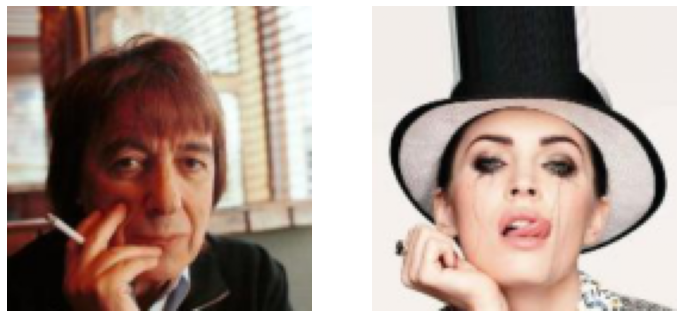

In [6]:
# prepare for pre-train
loss_fn = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(g.parameters(), lr=learning_rate)

Xi_train, _, _ = (next(iter(train_loader))) # Xi_val: [3, 3, 128, 128]
train_image_index = np.arange(0, len(train_set))

# low shots in the current training batch
plt.figure(figsize=(12, 8))
for i in range(len(Xi_train)):
    plt.subplot(1, len(Xi_train), i + 1)
    imgshow(Xi_train[i])
    plt.axis('off');

In [7]:
Z[[0]].shape

torch.Size([1, 128])

In [8]:
# pre-train
epoch_for_pre = 200
g, Z = pre_train(epoch_for_pre, 
                 train_loader, 
                 g, 
                 Z,
                 train_image_index,
                 optimizer, 
                 pretrain_decoder,
                  "./low_shots_celeb/checkpoint/current_decoder_pre_24_shots.pt")

Pre-train Epoch: 20 	 Average Loss: 0.016434
Pre-train Epoch: 40 	 Average Loss: 0.010367
Pre-train Epoch: 60 	 Average Loss: 0.006090
Pre-train Epoch: 80 	 Average Loss: 0.004686
Pre-train Epoch: 100 	 Average Loss: 0.003591
Pre-train Epoch: 120 	 Average Loss: 0.002888
Pre-train Epoch: 140 	 Average Loss: 0.002490
Pre-train Epoch: 160 	 Average Loss: 0.002286
Pre-train Epoch: 180 	 Average Loss: 0.001829
Pre-train Epoch: 200 	 Average Loss: 0.001755


In [9]:
Z.shape

torch.Size([24, 128])

In [5]:
# prepare for training
loss_fn = nn.MSELoss()
code_dim = 128
epoch_for_train_z = 1250
epoch_for_joint_train = 350

# final_output = torch.zeros((len(val_set), 3, 128, 128)).to(device)
# final_z_dict = torch.zeros((len(val_set), 1, code_dim)).to(device)


def train_all_val(mask):
    psnr_list = np.zeros(len(val_set))
    mask = mask.to(device)
    for i, (Xi_val, _, idx_val) in enumerate(val_loader):
        progress = tqdm(total=1, desc='loop % 3d' % i)
        # for image i
        Xi_val = Variable(Xi_val).to(device)
        Xi_val_noisy = (Xi_val * mask).to(device)

        # load pre-trained decoder
        train_decoder = Decoder(code_dim).to(device)
        if os.path.isfile("./low_shots_celeb/checkpoint/current_decoder_pre_24_shots.pt"):
            train_decoder.load_state_dict(torch.load("./low_shots_celeb/checkpoint/current_decoder_pre_24_shots.pt"))
        else:
            train_decoder.apply(weight_init)

        # initial z
        target_z = sample_multivar_normal(Z)

        # combined model train_g
        LV_target_z = LatentVariables(target_z).to(device)
        train_g = CombinedModel(LV_target_z, train_decoder).to(device)

        # train phase: train z to find z_hat
        target_z_hat, _ = train(epoch_for_train_z, 
                                Xi_val_noisy, 
                                train_g, 
                                train_decoder, 
                                target_z, 
                                joint_train=False,
                                learning_rate=5 * 1e-4,
                                save_path="./low_shots_celeb/checkpoint/current_checkpoint_train_z.pt",
                                mask=mask,
                                measure=None)

        # train phase: joint train
        warm_start_z = LatentVariables(target_z_hat).to(device)
        joint_train_g = CombinedModel(warm_start_z, train_decoder).to(device)

        final_z, final_G = train(epoch_for_joint_train, 
                             Xi_val_noisy, 
                             joint_train_g,
                             train_decoder, 
                             target_z_hat, 
                             joint_train=True,
                             learning_rate=1e-4,
                             save_path="./low_shots_celeb/checkpoint/current_checkpoint_final.pt",
                             mask=mask,
                             measure=None)

#         final_output[i] = final_G
#         final_z_dict[i] = final_z
        psnr_list[i] = psnr(Xi_val.cpu().numpy(), final_G.detach().cpu().numpy())

        progress.set_postfix({'loss': loss_fn(final_G * mask, Xi_val* mask).item()})
        progress.update()
        
    return np.mean(psnr_list)

In [6]:
# pretraining on 24 shots
average_pnsr_list_24_shots = []
for ratio, mask in zip(ratios, masks):
    print("for ratio:", ratio)
    snr = train_all_val(mask)
    average_pnsr_list_24_shots.append(snr)
    print("psnr = ", snr)
    clear_output(wait=True)

for ratio: 0.9


psnr =  31.104419523631993


[11.285993387963197, 12.379572090471278, 14.171125486758266, 21.51982343421712, 25.678263890672856, 28.575814761878963, 31.104419523631993]


Text(0.5, 1.0, '24 shots')

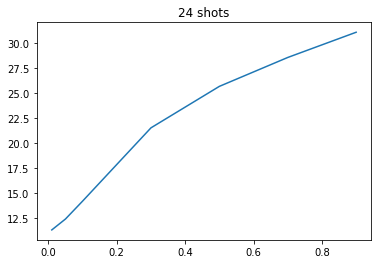

In [7]:
print(average_pnsr_list_24_shots)
plt.plot(ratios, average_pnsr_list_24_shots)
plt.title('24 shots')

In [10]:
# visual exam
final_output = torch.zeros((len(val_set), 3, 128, 128)).to(device)
final_z_dict = torch.zeros((len(val_set), 1, code_dim)).to(device)
psnr_list = np.zeros(len(val_set))

loss_fn = nn.MSELoss()
code_dim = 128
epoch_for_train_z = 1250
epoch_for_joint_train = 350

mask = masks[0].to(device)
for i, (Xi_val, _, idx_val) in enumerate(val_loader):
    progress = tqdm(total=1, desc='loop % 3d' % i)
    # for image i
    Xi_val = Variable(Xi_val).to(device)
    Xi_val_noisy = (Xi_val * mask).to(device)

    # load pre-trained decoder
    train_decoder = Decoder(code_dim).to(device)
    if os.path.isfile("./low_shots_celeb/checkpoint/current_decoder_pre_24_shots.pt"):
        train_decoder.load_state_dict(torch.load("./low_shots_celeb/checkpoint/current_decoder_pre_24_shots.pt"))
    else:
        train_decoder.apply(weight_init)

    # initial z
    target_z = sample_multivar_normal(Z)

    # combined model train_g
    LV_target_z = LatentVariables(target_z).to(device)
    train_g = CombinedModel(LV_target_z, train_decoder).to(device)

    # train phase: train z to find z_hat
    target_z_hat, _ = train(epoch_for_train_z, 
                            Xi_val_noisy, 
                            train_g, 
                            train_decoder, 
                            target_z, 
                            joint_train=False,
                            learning_rate=5 * 1e-4,
                            save_path="./low_shots_celeb/checkpoint/current_checkpoint_train_z.pt",
                            mask=mask,
                            measure=None)

    # train phase: joint train
    warm_start_z = LatentVariables(target_z_hat).to(device)
    joint_train_g = CombinedModel(warm_start_z, train_decoder).to(device)

    final_z, final_G = train(epoch_for_joint_train, 
                         Xi_val_noisy, 
                         joint_train_g,
                         train_decoder, 
                         target_z_hat, 
                         joint_train=True,
                         learning_rate=1e-4,
                         save_path="./low_shots_celeb/checkpoint/current_checkpoint_final.pt",
                         mask=mask,
                         measure=None)

    final_output[i] = final_G
    final_z_dict[i] = final_z
    psnr_list[i] = psnr(Xi_val.cpu().numpy(), final_G.detach().cpu().numpy())

    progress.set_postfix({'loss': loss_fn(final_G * mask, Xi_val* mask).item()})
    progress.update()

In [11]:
# visual results for inpainting task
def myimgshow(plt, img):
    plt.imshow(np.clip(img.data.cpu().numpy().squeeze().transpose(1, 2, 0), 0, 1))

def plot_all(plt, i):
    Xi_val, _, idx = val_set[i]
    Xi_val = Xi_val.to(device)
    
    fig = plt.figure(figsize = (15,15)) 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1, Xi_val)
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2, Xi_val * mask)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(Xi_val.cpu().numpy(), (Xi_val.cpu().numpy() * mask.cpu().numpy())))
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    myimgshow(ax3, final_output[idx])
    ax3.set_title( "Recovered image, PSNR: %.2f" % psnr(Xi_val.cpu().numpy(), final_output[idx].detach().cpu().numpy()) ) 
    ax3.axis('off')

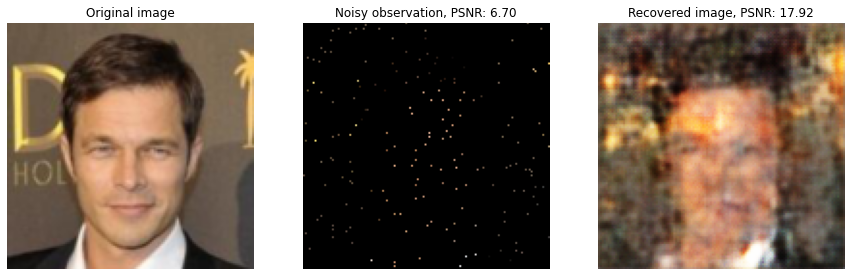

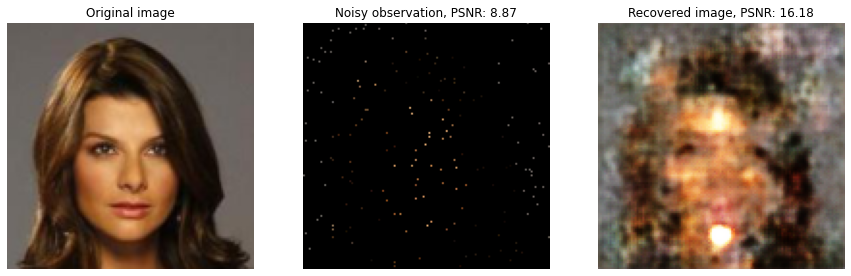

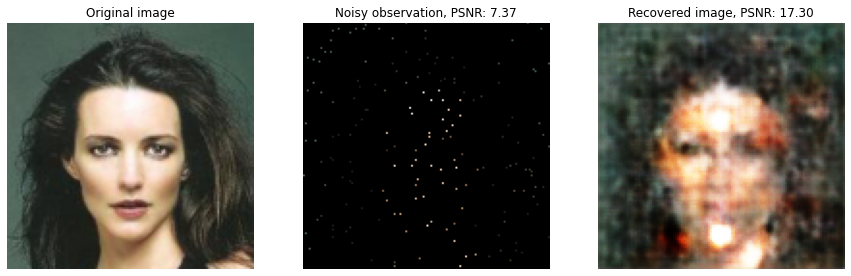

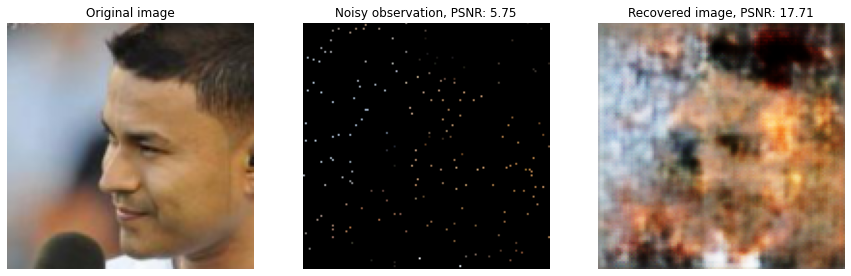

In [12]:
for i in range(5, 9):
    plot_all(plt, i)